In [1]:
from classMVA import MVA
import numpy as np
import matplotlib.pyplot as plt

# DATOS REALES. IMAGEN POR SATÉLITE


# 1. VALIDACIÓN SIN REGULARIZACIÓN PARA PCA

En primer lugar cargamos los datos:

In [2]:
import urllib2
from pyspark.mllib.regression import LabeledPoint

response = urllib2.urlopen("https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/satimage/sat.trn")
textdata = response.read()
datos = textdata.split('\n')


## 1.1 PCA CON SCIKIT LEARN

Creamos un numpy array con las variables y normalizamos eliminando la media

In [3]:
data_1_sk = np.array(map(lambda x: np.array(map(int, x.split(' ')[:-1])), datos[:-1]))
media = np.mean(data_1_sk, axis=0)
X_pca = data_1_sk - media


Con PCA de ScikitLearn extraemos 15 componentes y loa proyectamos

In [9]:
from sklearn.decomposition import PCA

nprojections = 15
pca = PCA(n_components=nprojections)
pca.fit(X_pca)
X_projected_sk = pca.transform(X_pca)

## 1.2 PCA CON LA TOOLBOX 

Creamos un RDD de Labeled Points para PCA de la Toolbox y entrenamos el modelo para 15 componentes 

In [11]:
RDD = sc.parallelize(textdata.split('\n')[:-1]).map(lambda line: line.split(" "))
RDD_labeled=RDD.map(lambda x: LabeledPoint(x[-1],x[0:-1]))
RDD_PCA = RDD_labeled.map(lambda x: x.features)

In [14]:
print RDD_PCA.count()

4435


In [15]:
PCA_model = MVA('PCA','none','None',1e-5,nprojections,1e-8,1e-5,100,30)
PCA_model.fit(RDD_PCA)

(15, 36)
(36, 36)
(36, 36)
Extracting projection vector 0 out of 15


KeyboardInterrupt: 

## 1.3 VISUALIZACIÓN

Dibujamos los vectores de proyección para las dos soluciones: en azul para PCA y en rojo para la Toolbox

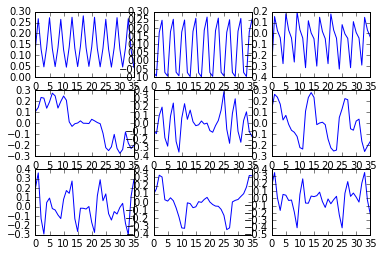

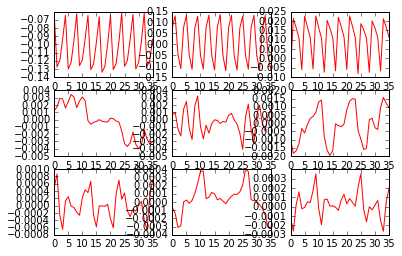

In [10]:
fig1 = plt.figure()

ax1 = fig1.add_subplot(331)
ax1.plot(pca.components_[0,], 'b-')

ax1 = fig1.add_subplot(332)
ax1.plot(pca.components_[1,], 'b-')

ax1 = fig1.add_subplot(333)
ax1.plot(pca.components_[2,], 'b-')

ax1 = fig1.add_subplot(334)
ax1.plot(pca.components_[3,], 'b-')

ax1 = fig1.add_subplot(335)
ax1.plot(pca.components_[4,], 'b-')

ax1 = fig1.add_subplot(336)
ax1.plot(pca.components_[5,], 'b-')

ax1 = fig1.add_subplot(337)
ax1.plot(pca.components_[6,], 'b-')

ax1 = fig1.add_subplot(338)
ax1.plot(pca.components_[7,], 'b-')

ax1 = fig1.add_subplot(339)
ax1.plot(pca.components_[8,], 'b-')


fig2 = plt.figure()

ax1 = fig2.add_subplot(331)
ax1.plot(PCA_model._U[0,], 'r-')

ax1 = fig2.add_subplot(332)
ax1.plot(PCA_model._U[1,], 'r-')

ax1 = fig2.add_subplot(333)
ax1.plot(PCA_model._U[2,], 'r-')

ax1 = fig2.add_subplot(334)
ax1.plot(PCA_model._U[3,], 'r-')

ax1 = fig2.add_subplot(335)
ax1.plot(PCA_model._U[4,], 'r-')

ax1 = fig2.add_subplot(336)
ax1.plot(PCA_model._U[5,], 'r-')

ax1 = fig2.add_subplot(337)
ax1.plot(PCA_model._U[6,], 'r-')

ax1 = fig2.add_subplot(338)
ax1.plot(PCA_model._U[7,], 'r-')

ax1 = fig2.add_subplot(339)
ax1.plot(PCA_model._U[8,], 'r-')


plt.show()


## 1.4 CÁLCULO DE MSE 

In [11]:
from sklearn.linear_model import LinearRegression

mses_sk = list()

n_targets = 36

for np2 in range(nprojections):
    mse = 0
    X_components_sk = X_projected_sk[:,:np2+1]
    for k in range(n_targets):
        targets = X_pca[:,k]
        
        #Entrenamos modelo
        lm = LinearRegression(fit_intercept=False)
        lm.fit(X_components_sk, targets)
        predictions = lm.predict(X_components_sk)
        
        MSE_iter = np.mean((targets-predictions)**2)
        mse += MSE_iter
    print 'MSE para ' + str(np2+1) + ' proyecciones: ' + str(mse)
    mses_sk.append(mse)

MSE para 1 proyecciones: 6259.91461541
MSE para 2 proyecciones: 1674.64018781
MSE para 3 proyecciones: 1261.20377487
MSE para 4 proyecciones: 970.887889414
MSE para 5 proyecciones: 725.09093335
MSE para 6 proyecciones: 523.864608692
MSE para 7 proyecciones: 387.465030233
MSE para 8 proyecciones: 325.025865326
MSE para 9 proyecciones: 277.677946905
MSE para 10 proyecciones: 237.304575517
MSE para 11 proyecciones: 208.42397999
MSE para 12 proyecciones: 187.349045486
MSE para 13 proyecciones: 167.387417121
MSE para 14 proyecciones: 149.335091491
MSE para 15 proyecciones: 134.622328256


In [ ]:
from sklearn.linear_model import LinearRegression

X_projected_tb = np.array(PCA_model.predict(RDD_PCA).collect())

X_pca = RDD_PCA.collect()
media = np.mean(X_pca, axis=0)
X_pca = X_pca-media


mses_tb = list()

n_targets = 36

for np2 in range(nprojections):
    mse = 0
    X_components_tb = X_projected_tb[:,:np2+1]
    for k in range(n_targets):
        targets = X_pca[:,k]
        
        #Entrenamos modelo
        lm = LinearRegression(fit_intercept=False)
        lm.fit(X_components_tb, targets)
        predictions = lm.predict(X_components_tb)
        
        MSE_iter = np.mean((targets-predictions)**2)
        mse += MSE_iter
    print 'MSE para ' + str(np2+1) + ' proyecciones: ' + str(mse)
    mses_tb.append(mse)

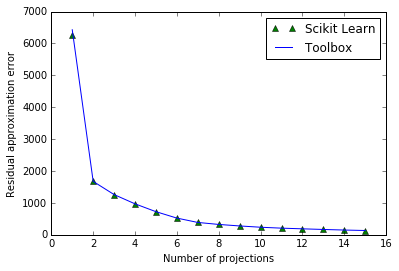

In [13]:

plt.figure()

plt.plot(map(lambda x: x+1, range(nprojections)), mses_sk, 'g^', label='Scikit Learn' )
plt.hold(True)
plt.plot(map(lambda x: x+1, range(nprojections)), mses_tb, 'b', label='Toolbox' )

plt.legend(loc = 1)
plt.xlabel('Number of projections')
plt.ylabel('Residual approximation error')

plt.show()

# 2. PCA VS OPLS (SIN REGULARIZAR)

Volvemos a cargar los datos.

De los 7 tipos de clases que puede haber, en los datos la clase 6 nunca aparace por lo que vamos a eliminarla.


In [27]:
import urllib2
from pyspark.mllib.regression import LabeledPoint

def filter_6 (x):
    if x==7.0:
        return 6.0
    else:
        return x

response = urllib2.urlopen("https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/satimage/sat.trn")
textdata = response.read()
RDD = sc.parallelize(textdata.split('\n')[:-1]).map(lambda line: line.split(" "))
RDD_labeled=RDD.map(lambda x: LabeledPoint(x[-1],x[0:-1]))
RDD_labeled=RDD_labeled.map(lambda x: LabeledPoint(filter_6(x.label), x.features))

Nos quedamos con el RDD para PCA

In [30]:
RDD_PCA = RDD_labeled.map(lambda x: x.features)

## 2.1 ENTRENAMOS LOS MODELOS

Entrenamos el modelo OPLS

In [32]:
nprojections=5
OPLS_model = MVA('OPLS','none','norm',1e-5,nprojections,1e-8,1e-5,100,30)
OPLS_model.fit(RDD_labeled)

(5, 36)
(6, 36)
(6, 6)
Extracting projection vector 0 out of 5
Extracting projection vector 1 out of 5
Extracting projection vector 2 out of 5
Extracting projection vector 3 out of 5
Extracting projection vector 4 out of 5
(5, 36)
(6, 36)
(6, 6)
Extracting projection vector 0 out of 5
Extracting projection vector 1 out of 5
Extracting projection vector 2 out of 5
Extracting projection vector 3 out of 5
Extracting projection vector 4 out of 5
Frobenius norm error: 4.19859787006e-05
(5, 36)
(6, 36)
(6, 6)
Extracting projection vector 0 out of 5
Extracting projection vector 1 out of 5
Extracting projection vector 2 out of 5
Extracting projection vector 3 out of 5
Extracting projection vector 4 out of 5
Frobenius norm error: 2.52423151508e-06


Entrenamos el modelo PCA

In [33]:
nprojections=15
PCA_model = MVA('PCA','none','None',1e-5,nprojections,1e-8,1e-5,100,30)
PCA_model.fit(RDD_PCA)

(15, 36)
(36, 36)
(36, 36)
Extracting projection vector 0 out of 15
Extracting projection vector 1 out of 15
Extracting projection vector 2 out of 15
Extracting projection vector 3 out of 15
Extracting projection vector 4 out of 15
Extracting projection vector 5 out of 15
Extracting projection vector 6 out of 15
Extracting projection vector 7 out of 15
Extracting projection vector 8 out of 15
Extracting projection vector 9 out of 15
Extracting projection vector 10 out of 15
Extracting projection vector 11 out of 15
Extracting projection vector 12 out of 15
Extracting projection vector 13 out of 15
Extracting projection vector 14 out of 15
(15, 36)
(36, 36)
(36, 36)
Extracting projection vector 0 out of 15
Extracting projection vector 1 out of 15
Extracting projection vector 2 out of 15
Extracting projection vector 3 out of 15
Extracting projection vector 4 out of 15
Extracting projection vector 5 out of 15
Extracting projection vector 6 out of 15
Extracting projection vector 7 out of 1

## 2.2 Calculamos el mse con |X-W^TX|^2 PARA OPLS Y PCA

In [34]:
from sklearn.linear_model import LinearRegression

RDD_new_feat=RDD_labeled.map(lambda x: x.features)

X_projected_tb_OPLS = np.array(OPLS_model.predict(RDD_new_feat).collect())

X_OPLS = RDD_new_feat.collect()
media = np.mean(X_OPLS, axis=0)
X_OPLS = X_OPLS-media
nprojections=5

mses_tb_opls = list()

n_targets = 36

for np2 in range(nprojections):
    mse = 0
    X_components_tb_opls = X_projected_tb_OPLS[:,:np2+1]
    for k in range(n_targets):
        targets = X_OPLS[:,k]
        
        #Entrenamos modelo
        lm = LinearRegression(fit_intercept=False)
        lm.fit(X_components_tb_opls, targets)
        predictions = lm.predict(X_components_tb_opls)
        
        MSE_iter = np.mean((targets-predictions)**2)
        mse += MSE_iter
    print 'MSE para ' + str(np2+1) + ' proyecciones: ' + str(mse)
    mses_tb_opls.append(mse)

classMVA.py:363: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._U != None:


MSE para 1 proyecciones: 6311.1192361
MSE para 2 proyecciones: 1783.58120041
MSE para 3 proyecciones: 1263.75290279
MSE para 4 proyecciones: 1008.8302509
MSE para 5 proyecciones: 828.807494242


In [35]:
from sklearn.linear_model import LinearRegression

X_projected_tb = np.array(PCA_model.predict(RDD_PCA).collect())

X_pca = RDD_PCA.collect()
media = np.mean(X_pca, axis=0)
X_pca = X_pca-media


nprojections=15
mses_tb = list()

n_targets = 36

for np2 in range(nprojections):
    mse = 0
    X_components_tb = X_projected_tb[:,:np2+1]
    for k in range(n_targets):
        targets = X_pca[:,k]
        
        #Entrenamos modelo
        lm = LinearRegression(fit_intercept=False)
        lm.fit(X_components_tb, targets)
        predictions = lm.predict(X_components_tb)
        
        MSE_iter = np.mean((targets-predictions)**2)
        mse += MSE_iter
    print 'MSE para ' + str(np2+1) + ' proyecciones: ' + str(mse)
    mses_tb.append(mse)

MSE para 1 proyecciones: 6430.87620532
MSE para 2 proyecciones: 1674.79261092
MSE para 3 proyecciones: 1261.28076844
MSE para 4 proyecciones: 970.929522491
MSE para 5 proyecciones: 725.097132359
MSE para 6 proyecciones: 523.865407288
MSE para 7 proyecciones: 387.465528125
MSE para 8 proyecciones: 325.026557129
MSE para 9 proyecciones: 277.67933127
MSE para 10 proyecciones: 237.30898655
MSE para 11 proyecciones: 208.428433889
MSE para 12 proyecciones: 187.391368539
MSE para 13 proyecciones: 167.426888348
MSE para 14 proyecciones: 149.335578549
MSE para 15 proyecciones: 134.654201316


Como podemos comprobar...

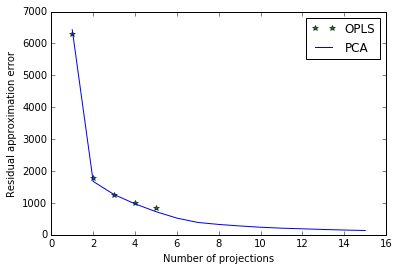

In [36]:
plt.figure()

plt.plot(map(lambda x: x+1, range(5)), mses_tb_opls, 'g*', label='OPLS' )
plt.hold(True)
plt.plot(map(lambda x: x+1, range(15)), mses_tb, 'b', label='PCA' )

plt.legend(loc = 1)
plt.xlabel('Number of projections')
plt.ylabel('Residual approximation error')

plt.show()

## 2.3 Calculamos el mse con |Y-W^TUX|^2

In [45]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import label_binarize
from pyspark.mllib.linalg import Vectors

X_projected_tb = np.array(PCA_model.predict(RDD_PCA).collect())

X_pca = RDD_PCA.collect()
media = np.mean(X_pca, axis=0)
X_pca = X_pca-media
set_classes = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
Y_pca_label=RDD_labeled.map(lambda x: Vectors.dense(label_binarize([x.label], classes=set_classes).flatten()))

Y_pca=np.array(Y_pca_label.collect())
media_y=np.mean(Y_pca,axis=0)

Y_pca=Y_pca-media_y


#print Y_pca.shape()
#print Y_pca
mses_tb_pca = list()
nprojections=15
n_targets = 6

for np2 in range(nprojections):
    mse = 0
    X_components_tb = X_projected_tb[:,:np2+1]
    for k in range(n_targets):
        targets =Y_pca[:,k]
        
        #Entrenamos modelo
        lm = LinearRegression(fit_intercept=False)
        lm.fit(X_components_tb, targets)
        predictions = lm.predict(X_components_tb)
        
        MSE_iter = np.mean((targets-predictions)**2)
        mse += MSE_iter
    print 'MSE para ' + str(np2+1) + ' proyecciones: ' + str(mse)
    mses_tb_pca.append(mse)

MSE para 1 proyecciones: 0.682532461254
MSE para 2 proyecciones: 0.572069727411
MSE para 3 proyecciones: 0.381955509258
MSE para 4 proyecciones: 0.381365682415
MSE para 5 proyecciones: 0.37956713779
MSE para 6 proyecciones: 0.378435556685
MSE para 7 proyecciones: 0.377879467237
MSE para 8 proyecciones: 0.377206284913
MSE para 9 proyecciones: 0.377102157647
MSE para 10 proyecciones: 0.376890505145
MSE para 11 proyecciones: 0.375870440353
MSE para 12 proyecciones: 0.375174421278
MSE para 13 proyecciones: 0.373398916164
MSE para 14 proyecciones: 0.369263063009
MSE para 15 proyecciones: 0.368872174342


In [46]:
RDD_new_feat=RDD_labeled.map(lambda x: x.features)

X_projected_tb_OPLS = np.array(OPLS_model.predict(RDD_new_feat).collect())

nprojections=5

mses_tb_opls = list()

n_targets = 6

for np2 in range(nprojections):
    mse = 0
    X_components_tb_opls = X_projected_tb_OPLS[:,:np2+1]
    for k in range(n_targets):
        targets = Y_pca[:,k]
        
        #Entrenamos modelo
        lm = LinearRegression(fit_intercept=False)
        lm.fit(X_components_tb_opls, targets)
        predictions = lm.predict(X_components_tb_opls)
        
        MSE_iter = np.mean((targets-predictions)**2)
        mse += MSE_iter
    print 'MSE para ' + str(np2+1) + ' proyecciones: ' + str(mse)
    mses_tb_opls.append(mse)

MSE para 1 proyecciones: 0.688028191414
MSE para 2 proyecciones: 0.562683547375
MSE para 3 proyecciones: 0.379832115991
MSE para 4 proyecciones: 0.377901307755
MSE para 5 proyecciones: 0.376772376092


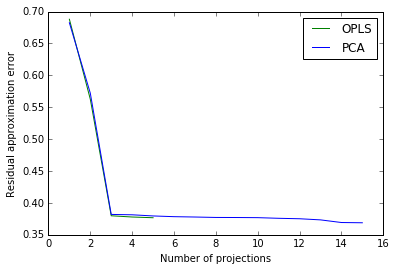

In [47]:
plt.figure()

plt.plot(map(lambda x: x+1, range(5)), mses_tb_opls, 'g', label='OPLS' )
plt.hold(True)
plt.plot(map(lambda x: x+1, range(15)), mses_tb_pca, 'b', label='PCA' )

plt.legend(loc = 1)
plt.xlabel('Number of projections')
plt.ylabel('Residual approximation error')

plt.show()

# 3. OPLS REGULARIZADO

In [48]:
import urllib2
from pyspark.mllib.regression import LabeledPoint

response = urllib2.urlopen("https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/satimage/sat.trn")
textdata = response.read()
RDD = sc.parallelize(textdata.split('\n')[:-1]).map(lambda line: line.split(" "))
RDD_labeled=RDD.map(lambda x: LabeledPoint(x[-1],x[0:-1]))

In [49]:
def filter_6 (x):
    if x==7.0:
        return 6.0
    else:
        return x
    

rdd_label= RDD_labeled.map(lambda x: x.label)
rdd_label_new=rdd_label.map(lambda x: filter_6(x))
label=rdd_label_new.distinct().collect()

new=RDD_labeled.map(lambda x: x.features).zip(rdd_label_new)
RDD_labeled_new=new.map(lambda x: LabeledPoint(x[1],x[0]))

In [50]:
term_reg=list()
reg1=0.00001
term_reg.append(reg1)
reg2=0.1
term_reg.append(reg2)
reg3=0.99
term_reg.append(reg3)


In [ ]:
nprojections=6
U_opls_reg=list()

for i in range(len(term_reg)):
    
    OPLS_model = MVA('OPLS','l1','norm',1e-5,nprojections,term_reg[i],1e-5,100,30)
    OPLS_model.fit(RDD_labeled_new)
    U_opls_reg.append(OPLS_model._U)

(5, 36)
(6, 36)
(6, 6)
Extracting projection vector 0 out of 5
Extracting projection vector 1 out of 5
Extracting projection vector 2 out of 5
Extracting projection vector 3 out of 5
Extracting projection vector 4 out of 5
(5, 36)
(6, 36)
(6, 6)
Extracting projection vector 0 out of 5
Extracting projection vector 1 out of 5
Extracting projection vector 2 out of 5
Extracting projection vector 3 out of 5
Extracting projection vector 4 out of 5
Frobenius norm error: 5.46579872993e-05
(5, 36)
(6, 36)
(6, 6)
Extracting projection vector 0 out of 5
Extracting projection vector 1 out of 5
Extracting projection vector 2 out of 5
Extracting projection vector 3 out of 5
Extracting projection vector 4 out of 5
Frobenius norm error: 4.04801182771e-06
(5, 36)
(6, 36)
(6, 6)
Extracting projection vector 0 out of 5
Extracting projection vector 1 out of 5
Extracting projection vector 2 out of 5
Extracting projection vector 3 out of 5
Extracting projection vector 4 out of 5
(5, 36)
(6, 36)
(6, 6)
Extra

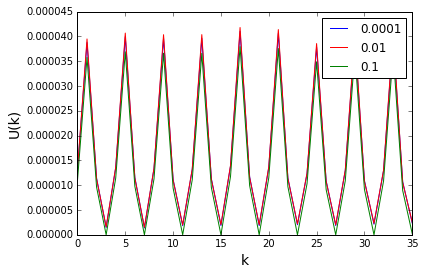

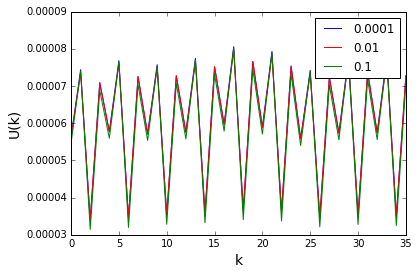

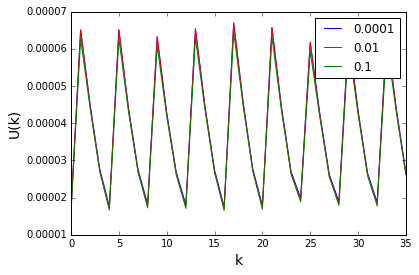

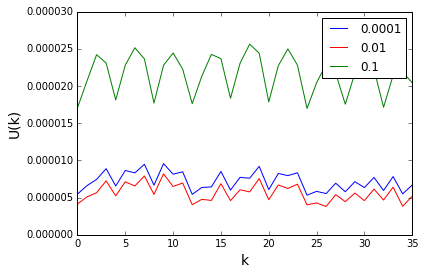

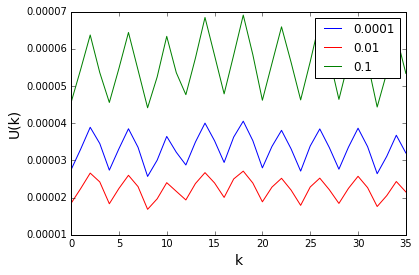

In [35]:
import matplotlib.pyplot as plt

for i in range(5):
    
    plt.figure()
    #ax1 = fig1.add_subplot(331)
    #ax1.plot(pca.components_[0,], 'b-')
    #arreglar
    
    plt.plot(abs(U_opls_reg[0].T[:,i]),'b',label=term_reg[0])
    plt.hold(True)
    plt.plot(abs(U_opls_reg[1].T[:,i]),'r',label=term_reg[1])
    plt.hold(True)
    plt.plot(abs(U_opls_reg[2].T[:,i]),'g',label=term_reg[2])

    plt.legend(loc = 1)

    plt.xlabel('k', fontsize=14)
    plt.ylabel('U(k)', fontsize=14)


    plt.show()
    

# DATOS SINTÉTICOS

# 1. PCA VS OPLS

Se van a crear unos datos sintéticos se podrá modificar en la siguiente celda de ajuste:

In [2]:
import numpy as numpy
#Number of samples
np=1050000
#Number of inputs
nx=10
#Number of outputs
ny=5
#Variance of X
VarX=numpy.array([1, 1e-1, 1e-2,1e-3,1e-4,1e-5,1e-6,1e-7,1e-8,1e-9])

In [3]:
X = numpy.random.randn(np,nx) * VarX
W=numpy.random.randn(nx,ny)
Y=X.dot(W)

In [4]:
RDD_X = sc.parallelize(X.tolist())
RDD_Y = sc.parallelize(Y.tolist())

RDD_labeled = RDD_Y.zip(RDD_X)

# 2. ESCALABILIDAD 

In [5]:
samples=numpy.array([0.01,0.1,1])

In [ ]:
#RDD for OPLS
RDD_1=RDD_labeled.sample(False, samples[0], 80)
RDD_2=RDD_labeled.sample(False, samples[1], 80)
RDD_3=RDD_labeled
ESC_RDD_OPLS=[RDD_1,RDD_2,RDD_3]

#RDD for PCA
RDD_PCA=RDD_labeled.map(lambda x: x[1])
RDD_1=RDD_PCA.sample(False, samples[0], 80)
RDD_2=RDD_PCA.sample(False, samples[1], 80)
RDD_3=RDD_PCA
ESC_RDD_PCA=[RDD_1,RDD_2,RDD_3]

In [ ]:
from classMVA import MVA
import time 

for i in range(3):
    print 'hola'
    prueba = MVA('PCA','l1','None',1e-5,10,0.01,1e-3,100,30)
    print 'INIT TIME FOR ' + str(i+1) + ' samples ' + str(time.localtime( time.time() ))
    RDD_PCA_ESC=ESC_RDD_PCA[i]
    #print RDD_PCA_ESC.count()
    prueba.fit(RDD_PCA_ESC)
    print 'END TIME FOR RDD ' + str(i+1) + ' samples ' + str(time.localtime( time.time() ))


In [54]:
from classMVA import MVA
import time 

for i in range(3):
    prueba = MVA('OPLS','l1','norm',1e-5,10,0.01,1e-3,100,30)
    print 'INIT TIME FOR ' + str(i+1) + ' samples ' + str(time.localtime( time.time() ))
    RDD_OPLS_ESC=ESC_RDD_OPLS[i]
    prueba.fit(RDD_OPLS_ESC)
    print 'END TIME FOR RDD ' + str(i+1) + ' samples ' + str(time.localtime( time.time() ))


INIT TIME FOR 1 samples time.struct_time(tm_year=2017, tm_mon=7, tm_mday=5, tm_hour=17, tm_min=35, tm_sec=10, tm_wday=2, tm_yday=186, tm_isdst=1)
(4, 10)
(5, 10)
(5, 5)
Extracting projection vector 0 out of 4
Extracting projection vector 1 out of 4
Extracting projection vector 2 out of 4
Extracting projection vector 3 out of 4
(4, 10)
(5, 10)
(5, 5)
Extracting projection vector 0 out of 4
Extracting projection vector 1 out of 4
Extracting projection vector 2 out of 4
Extracting projection vector 3 out of 4
Frobenius norm error: 4.82289829814e-07
END TIME FOR RDD 1 samples time.struct_time(tm_year=2017, tm_mon=7, tm_mday=5, tm_hour=17, tm_min=36, tm_sec=49, tm_wday=2, tm_yday=186, tm_isdst=1)
INIT TIME FOR 2 samples time.struct_time(tm_year=2017, tm_mon=7, tm_mday=5, tm_hour=17, tm_min=36, tm_sec=49, tm_wday=2, tm_yday=186, tm_isdst=1)
(4, 10)
(5, 10)
(5, 5)
Extracting projection vector 0 out of 4
Extracting projection vector 1 out of 4
Extracting projection vector 2 out of 4
Extracting

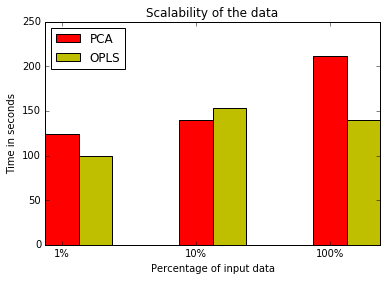

In [59]:
import numpy as np
import matplotlib.pyplot as plt

N = 3
timePca = (124,140,211)
timeOpls=(99,153,140)

ind = np.arange(N)  # the x locations for the groups
width = 0.25       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, timePca, width, color='r')
rects2 = ax.bar(ind + width, timeOpls, width, color='y')

ax.set_ylabel('Time in seconds')
ax.set_xlabel('Percentage of input data')
ax.set_title('Scalability of the data')
ax.set_xticks(ind+ width / 2)
ax.set_xticklabels(('1%','10%','100%'))


ax.legend((rects1[0], rects2[0]), ('PCA', 'OPLS'),loc=2)

plt.show()